# TEMPO Development Notebook

**T**rajectory **E**nrichment via **M**atrix **P**rofile **O**utcomes

This notebook is a living document that grows alongside the package. Each section corresponds to one TEMPO module and shows it in action — what it computes, why, and what the output looks like. Sections are meant to be read top-to-bottom on a first pass, then re-run section-by-section as new modules are implemented.

| Module | Status | Purpose |
|--------|--------|---------|
| `simulate` | ✅ Implemented | Generate synthetic ground-truth data |
| `preprocess` | ✅ Implemented | Normalise and reduce trajectories |
| `harbinger` | ✅ Implemented | Matrix profile motif discovery |
| `stats` | ✅ Implemented | Permutation tests, enrichment scores, survival |
| `viz` | ✅ Implemented | Publication-ready plotting API |

---
## Setup

Standard imports used throughout the notebook. `seaborn` theme is applied globally so all matplotlib figures pick it up automatically.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from tempo import simulate

sns.set_theme(style='whitegrid', palette='muted')
case_color = '#e05c5c'
ctrl_color = '#5c8ae0'
print('tempo imported OK')

tempo imported OK


---
## 1  `simulate` — Longitudinal Compositional Data

### What is compositional data?

Microbiome readouts (16S rRNA sequencing) measure the *relative abundance* of taxa — they tell you what fraction of reads belong to each taxon, not the absolute counts. This means that at every timepoint, the values across all features sum to exactly 1. This is the **compositional constraint**, and it has major statistical consequences:

- Features are not independent — if one goes up, others must go down.
- Standard Euclidean distances are misleading on the simplex.
- Log-ratio methods (e.g. CLR) are usually required before any linear analysis.

### How `simulate_longitudinal` works

1. **Baseline composition**: each subject gets a Dirichlet-sampled starting composition (sums to 1). The Dirichlet distribution is the natural prior over compositions (it's what you'd use if you wanted a random point on the probability simplex).
2. **Random walk**: at each subsequent timepoint, compositions drift in log-space via Gaussian noise. Log-space is used so values stay positive.
3. **Motif embedding**: for *case* subjects, the features listed in `motif_features` are multiplicatively boosted during the `motif_window` timepoints. This mimics a bloom or enrichment event that distinguishes cases from controls.
4. **Re-normalisation**: after boosting, the composition is renormalised to sum to 1 again.
5. **Zero inflation**: a fraction of values are zeroed out to mimic the sparsity typical of real 16S data (many taxa are absent in most samples).

The ground truth (which features carry the motif, and when) is stored in `df.attrs` so we can later evaluate how well the Harbinger analysis recovers it.

In [2]:
df = simulate.simulate_longitudinal(
    n_subjects=40,
    n_timepoints=12,
    n_features=20,
    n_cases=15,
    motif_features=[0, 1, 2],   # features 0, 1, 2 carry the signal
    motif_window=(4, 8),         # signal is present at timepoints 4 through 8
    motif_strength=2.5,          # case values are 2.5x higher in the motif window
    noise_sd=0.2,                # gaussian noise on log-trajectories
    zero_inflation=0.1,          # 10% of values replaced with 0
    seed=42,
)

truth = simulate.get_ground_truth(df)
window = truth['motif_window']
features = sorted(df['feature'].unique())
timepoints = sorted(df['timepoint'].unique())

print(f'Shape: {df.shape}  (subjects × timepoints × features rows)')
print(f'Subjects: {df.subject_id.nunique()} '
      f'({df[df.outcome==1].subject_id.nunique()} cases, '
      f'{df[df.outcome==0].subject_id.nunique()} controls)')
print(f'\nGround truth:')
print(f'  Motif features : {truth["motif_features"]}')
print(f'  Motif window   : timepoints {window[0]}–{window[1]}')
df.head(6)

Shape: (9600, 5)  (subjects × timepoints × features rows)
Subjects: 40 (15 cases, 25 controls)

Ground truth:
  Motif features : ['feature_000', 'feature_001', 'feature_002']
  Motif window   : timepoints 4–8


,subject_id,timepoint,feature,value,outcome
0,case_000,0,feature_000,0.060620,1
1,case_000,0,feature_001,0.082167,1
2,case_000,0,feature_002,0.053242,1
3,case_000,0,feature_003,0.047673,1
4,case_000,0,feature_004,0.000000,1
5,case_000,0,feature_005,0.050812,1


### Verifying the compositional constraint

Before visualising, confirm that the simulation is behaving correctly: values across all features should sum to 1.0 at every (subject, timepoint) combination. The small tolerance (`atol=1e-6`) accounts for floating-point rounding.

In [3]:
sums = df.groupby(['subject_id', 'timepoint'])['value'].sum()
print(f'Value sums — min: {sums.min():.8f}, max: {sums.max():.8f}')
print(f'Zero rate: {(df.value == 0).mean():.1%}  (target ~10%)')

Value sums — min: 1.00000000, max: 1.00000000
Zero rate: 10.1%  (target ~10%)


### Plot 1 — Individual trajectories

Each line is one subject over time. We show three motif features (top row) and three noise features (bottom row). Within the gold-shaded **motif window**, case subjects (red) should visibly separate from controls (blue) in the motif features, but not in the noise features. The signal is subtle here because the compositional renormalisation partially absorbs the boost — this is a key reason why CLR preprocessing is important.

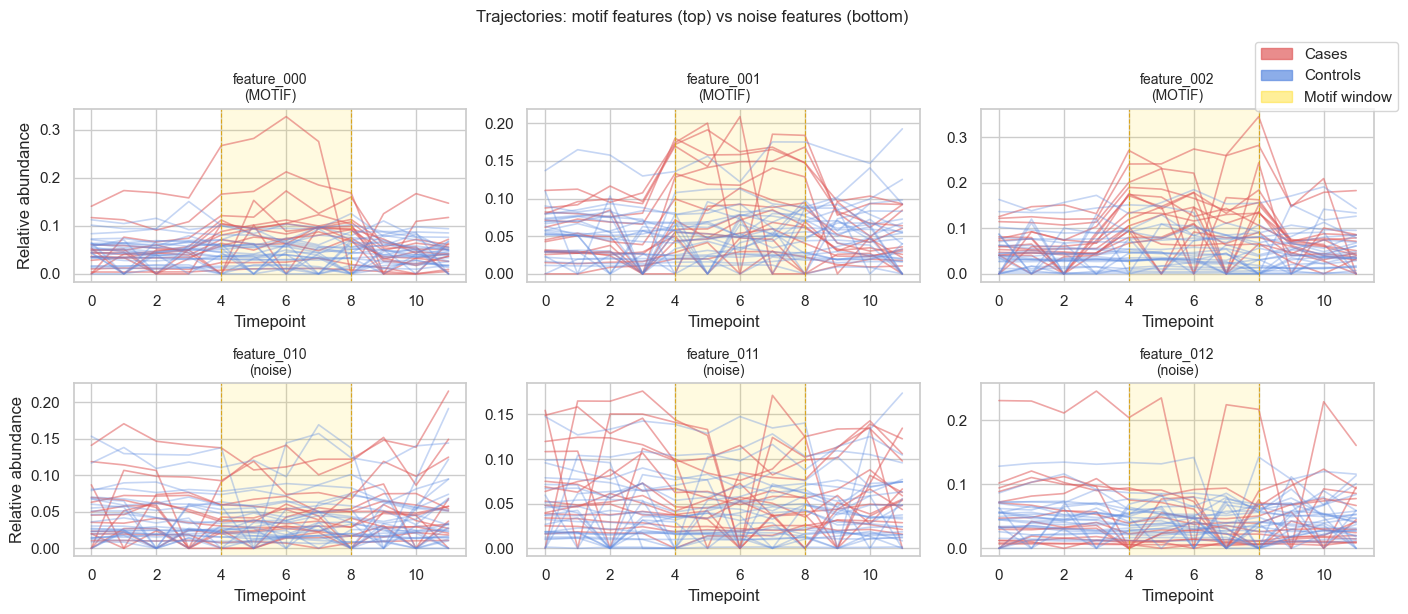

In [4]:
motif_feats = truth['motif_features']
noise_feats = ['feature_010', 'feature_011', 'feature_012']

fig, axes = plt.subplots(2, 3, figsize=(14, 6), sharey=False)

for row_idx, feat_group in enumerate([motif_feats, noise_feats]):
    for col_idx, feat in enumerate(feat_group):
        ax = axes[row_idx, col_idx]
        feat_df = df[df['feature'] == feat]

        for subj, grp in feat_df.groupby('subject_id'):
            outcome = grp['outcome'].iloc[0]
            color = case_color if outcome == 1 else ctrl_color
            alpha = 0.55 if outcome == 1 else 0.35
            ax.plot(grp['timepoint'], grp['value'], color=color, alpha=alpha, lw=1.2)

        ax.axvspan(window[0], window[1], alpha=0.12, color='gold')
        ax.axvline(window[0], color='goldenrod', lw=0.8, ls='--')
        ax.axvline(window[1], color='goldenrod', lw=0.8, ls='--')
        label = f'{feat}\n(MOTIF)' if row_idx == 0 else f'{feat}\n(noise)'
        ax.set_title(label, fontsize=10)
        ax.set_xlabel('Timepoint')
        if col_idx == 0:
            ax.set_ylabel('Relative abundance')

case_patch = mpatches.Patch(color=case_color, label='Cases', alpha=0.7)
ctrl_patch = mpatches.Patch(color=ctrl_color, label='Controls', alpha=0.7)
window_patch = mpatches.Patch(color='gold', label='Motif window', alpha=0.4)
fig.legend(handles=[case_patch, ctrl_patch, window_patch],
           loc='upper right', bbox_to_anchor=(1.01, 0.98))
fig.suptitle('Trajectories: motif features (top) vs noise features (bottom)',
             fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

### Plot 2 — Group mean ± SD

Averaging across all subjects in each group and showing ±1 SD makes the signal much clearer. Within the motif window, the case mean (red) should rise above the control mean (blue) for motif features, but not for noise features. The SD bands give a sense of how variable the trajectories are — wide bands mean the signal is buried in noise for individual subjects.

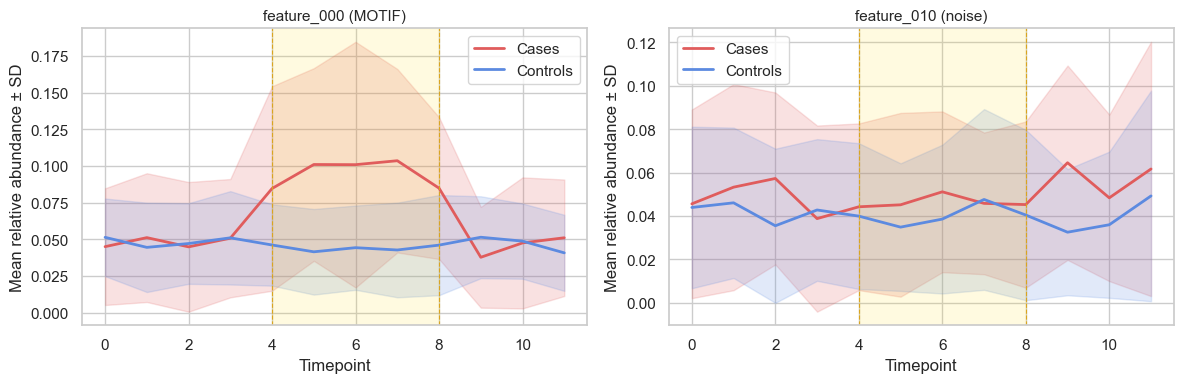

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, feat, title in zip(
    axes,
    ['feature_000', 'feature_010'],
    ['feature_000 (MOTIF)', 'feature_010 (noise)']
):
    feat_df = df[df['feature'] == feat]
    for outcome, label, color in [(1, 'Cases', case_color), (0, 'Controls', ctrl_color)]:
        grp = feat_df[feat_df['outcome'] == outcome].groupby('timepoint')['value']
        means, stds = grp.mean(), grp.std()
        ax.plot(means.index, means.values, color=color, lw=2, label=label)
        ax.fill_between(means.index, means - stds, means + stds,
                        color=color, alpha=0.18)
    ax.axvspan(window[0], window[1], alpha=0.12, color='gold')
    ax.axvline(window[0], color='goldenrod', lw=0.8, ls='--')
    ax.axvline(window[1], color='goldenrod', lw=0.8, ls='--')
    ax.set_title(title, fontsize=11)
    ax.set_xlabel('Timepoint')
    ax.set_ylabel('Mean relative abundance ± SD')
    ax.legend()

plt.tight_layout()
plt.show()

### Plot 3 — All-features difference heatmap

This is the most compact summary: every feature on Y, every timepoint on X, colour = mean(case) − mean(ctrl). A well-behaved simulation should show a warm (red) block in the top rows (motif features, labelled in red) aligned with the gold motif window columns. Everything else should be near zero (white). This view scales well to 100+ features without cluttering.

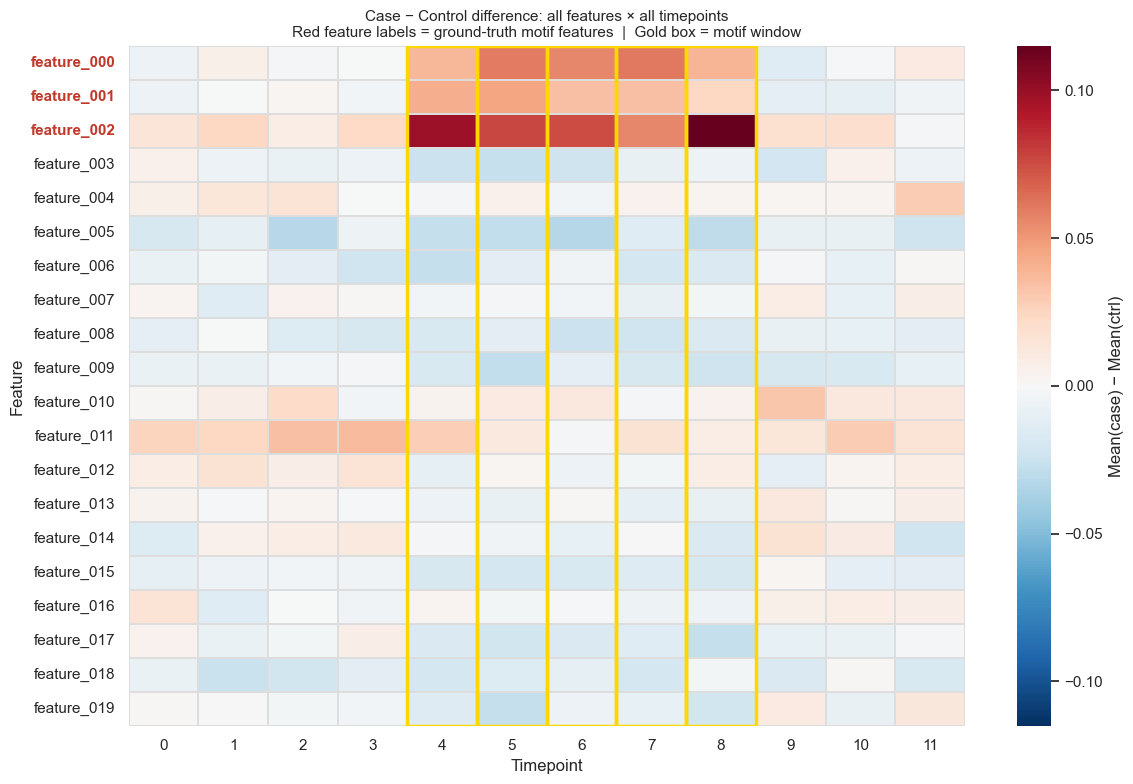

In [6]:
case_mean = (
    df[df['outcome'] == 1]
    .groupby(['feature', 'timepoint'])['value'].mean()
    .unstack('timepoint').reindex(features)[timepoints]
)
ctrl_mean = (
    df[df['outcome'] == 0]
    .groupby(['feature', 'timepoint'])['value'].mean()
    .unstack('timepoint').reindex(features)[timepoints]
)
diff = case_mean - ctrl_mean

fig, ax = plt.subplots(figsize=(12, 8))
vmax = np.abs(diff.values).max()
sns.heatmap(
    diff, ax=ax,
    cmap='RdBu_r', center=0, vmin=-vmax, vmax=vmax,
    linewidths=0.3, linecolor='#dddddd',
    cbar_kws={'label': 'Mean(case) − Mean(ctrl)'},
)

for tp in range(window[0], window[1] + 1):
    col_idx = timepoints.index(tp)
    ax.add_patch(plt.Rectangle(
        (col_idx, 0), 1, len(features),
        fill=False, edgecolor='gold', lw=2.5, zorder=5
    ))

for lbl in ax.get_yticklabels():
    if lbl.get_text() in truth['motif_features']:
        lbl.set_color('#c0392b')
        lbl.set_fontweight('bold')

ax.set_title(
    'Case − Control difference: all features × all timepoints\n'
    'Red feature labels = ground-truth motif features  |  Gold box = motif window',
    fontsize=11
)
ax.set_xlabel('Timepoint')
ax.set_ylabel('Feature')
plt.tight_layout()
plt.show()

---
## 2  `simulate` — Continuous Data (step / ramp / pulse)

### Why a separate continuous simulator?

Not all biological data is compositional. Flow cytometry cell counts, gene expression (TPM), and clinical measurements don't sum to 1 — each feature is independent and lives on the real line. `simulate_continuous` generates data with these properties and also lets us test three different **motif shapes** that map to different biological phenomena:

- **Step**: a sustained elevation during the window (e.g. immune cell activation   that stays elevated once triggered).
- **Ramp**: a linear increase (e.g. gradual clonal expansion over the window).
- **Pulse**: a transient spike at the window midpoint (e.g. an acute inflammatory   burst that resolves quickly).

Because there's no compositional constraint, the signal-to-noise ratio is much cleaner and makes this a good dataset for testing the harbinger algorithm before moving to the harder compositional case.

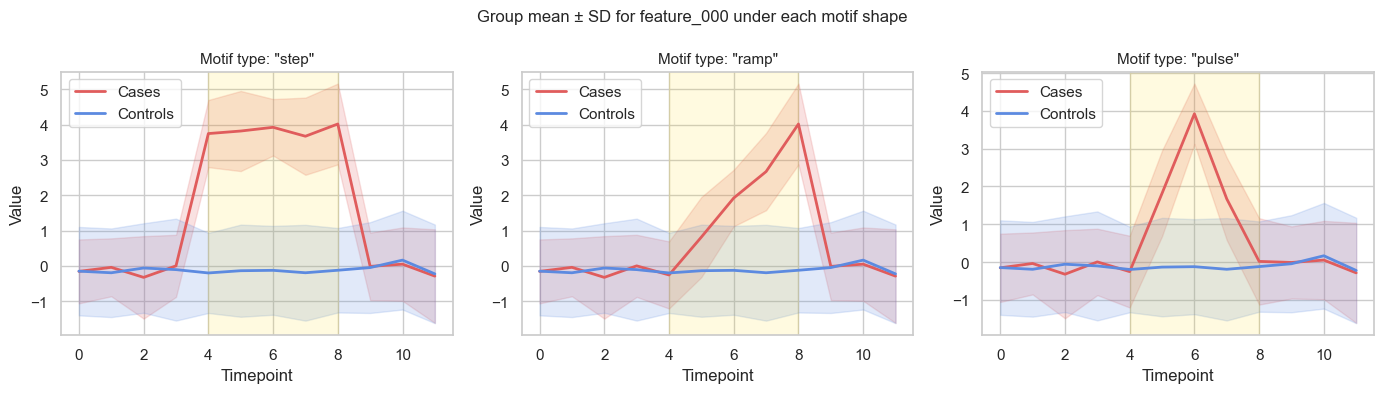

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=False)

for ax, motif_type in zip(axes, ['step', 'ramp', 'pulse']):
    df_c = simulate.simulate_continuous(
        n_subjects=30, n_timepoints=12, n_features=5, n_cases=10,
        motif_features=[0], motif_window=(4, 8),
        motif_type=motif_type, motif_strength=4.0, noise_sd=0.5, seed=0
    )
    feat_df = df_c[df_c['feature'] == 'feature_000']

    for outcome, label, color in [(1, 'Cases', case_color), (0, 'Controls', ctrl_color)]:
        grp = feat_df[feat_df['outcome'] == outcome].groupby('timepoint')['value']
        means, stds = grp.mean(), grp.std()
        ax.plot(means.index, means.values, color=color, lw=2, label=label)
        ax.fill_between(means.index, means - stds, means + stds, color=color, alpha=0.18)

    ax.axvspan(4, 8, alpha=0.12, color='gold')
    ax.set_title(f'Motif type: "{motif_type}"', fontsize=11)
    ax.set_xlabel('Timepoint')
    ax.set_ylabel('Value')
    ax.legend()

fig.suptitle('Group mean ± SD for feature_000 under each motif shape', fontsize=12)
plt.tight_layout()
plt.show()

---
## 3  `simulate` — Outcome Types

TEMPO is designed to work with three different study designs:

- **Binary** (default): case/control — the most common design.   Outcome is 0 or 1 per subject.
- **Continuous**: a quantitative phenotype (e.g. a clinical score).   Useful for testing enrichment methods that correlate trajectories   with a continuous variable rather than a binary label.
- **Survival**: time-to-event data with censoring.   Cases get earlier synthetic events; controls are censored later.   This is the design for survival-integrated trajectory analysis via `stats.survival_test()`.

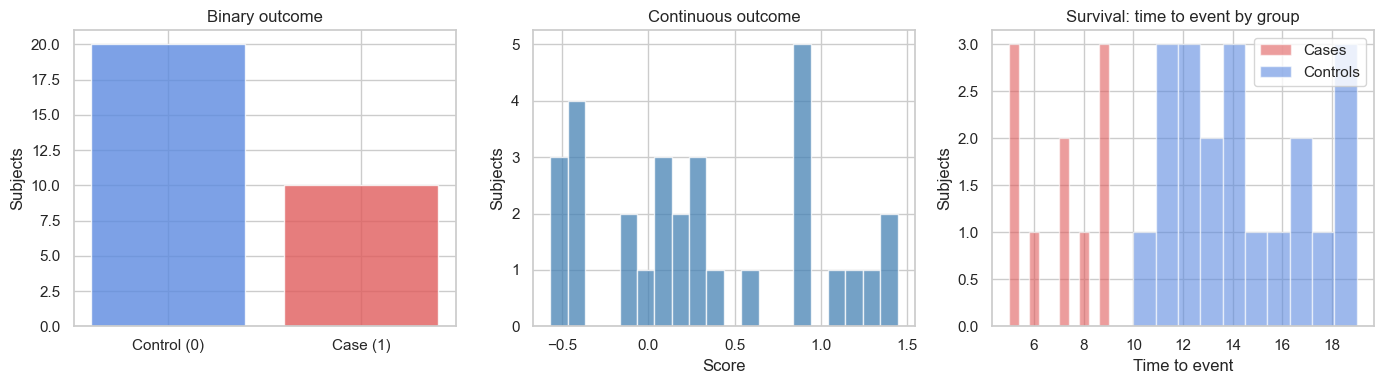

In [8]:
df_binary    = simulate.simulate_longitudinal(outcome_type='binary', seed=0)
df_continuous = simulate.simulate_longitudinal(outcome_type='continuous', seed=0)
df_survival  = simulate.simulate_longitudinal(outcome_type='survival', seed=0)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Binary: simple case/control counts
counts = df_binary.drop_duplicates('subject_id')['outcome'].value_counts()
axes[0].bar(['Control (0)', 'Case (1)'], [counts.get(0, 0), counts.get(1, 0)],
            color=[ctrl_color, case_color], alpha=0.8)
axes[0].set_title('Binary outcome')
axes[0].set_ylabel('Subjects')

# Continuous: distribution of outcome scores
axes[1].hist(df_continuous.drop_duplicates('subject_id')['outcome'],
             bins=20, color='steelblue', alpha=0.75)
axes[1].set_title('Continuous outcome')
axes[1].set_xlabel('Score')
axes[1].set_ylabel('Subjects')

# Survival: time-to-event distributions by group
subjects_s = df_survival.drop_duplicates('subject_id')
for outcome, label, color in [(1, 'Cases', case_color), (0, 'Controls', ctrl_color)]:
    grp = subjects_s[subjects_s['outcome'] == outcome]['time_to_event']
    axes[2].hist(grp, bins=10, alpha=0.6, label=label, color=color)
axes[2].set_title('Survival: time to event by group')
axes[2].set_xlabel('Time to event')
axes[2].set_ylabel('Subjects')
axes[2].legend()

plt.tight_layout()
plt.show()

---
## 4  `simulate` — `evaluation_report`

### Why do we need an evaluation framework?

Once Harbinger analysis returns a list of features and a motif window, we need an objective way to ask: *how close did it get to the truth?* Because we simulated the data ourselves, we know the true answer (stored in `df.attrs`), so we can compute three metrics:

- **Feature recall**: what fraction of the true motif features did we detect?   `|detected ∩ true| / |true|`
- **Feature precision**: of the features we flagged, what fraction were actually motif features?   `|detected ∩ true| / |detected|`
- **Window Jaccard**: how much do the detected and true windows overlap?   Jaccard index = `|detected ∩ true| / |detected ∪ true|`,   treating each timepoint as a set element. 1.0 = perfect overlap, 0.0 = no overlap.

This is the evaluation loop we'll run after every harbinger result to track how the algorithm improves as we tune it.

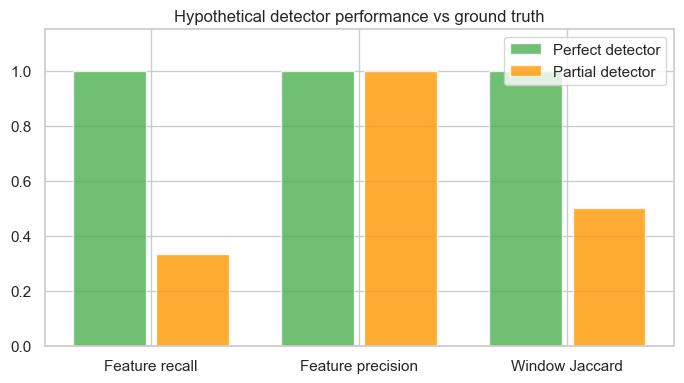

Perfect detector: {'feature_recall': 1.0, 'feature_precision': 1.0, 'window_jaccard': 1.0, 'true_features': ['feature_001', 'feature_002', 'feature_000'], 'detected_features': ['feature_001', 'feature_002', 'feature_000'], 'true_window': (3, 7), 'detected_window': (3, 7)}
Partial detector: {'feature_recall': 0.333, 'feature_precision': 1.0, 'window_jaccard': 0.5, 'true_features': ['feature_001', 'feature_002', 'feature_000'], 'detected_features': ['feature_000'], 'true_window': (3, 7), 'detected_window': (5, 8)}


In [9]:
df_eval = simulate.simulate_longitudinal(
    motif_features=[0, 1, 2], motif_window=(3, 7), seed=0
)

# Imagine two hypothetical detectors
perfect = simulate.evaluation_report(
    detected_features=['feature_000', 'feature_001', 'feature_002'],
    detected_window=(3, 7), df=df_eval
)
partial = simulate.evaluation_report(
    detected_features=['feature_000'],
    detected_window=(5, 8), df=df_eval
)

metrics = ['feature_recall', 'feature_precision', 'window_jaccard']
fig, ax = plt.subplots(figsize=(7, 4))
x = np.arange(len(metrics))
ax.bar(x - 0.2, [perfect[m] for m in metrics], 0.35,
       label='Perfect detector', color='#4caf50', alpha=0.8)
ax.bar(x + 0.2, [partial[m] for m in metrics], 0.35,
       label='Partial detector', color='#ff9800', alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels(['Feature recall', 'Feature precision', 'Window Jaccard'])
ax.set_ylim(0, 1.15)
ax.set_title('Hypothetical detector performance vs ground truth')
ax.legend()
plt.tight_layout()
plt.show()

print('Perfect detector:', perfect)
print('Partial detector:', partial)

---
## 5  `preprocess` — ✅ Implemented

### Why preprocess at all?

Raw compositional values have two properties that make them unsuitable for matrix profile analysis:

1. **The simplex constraint**: because values sum to 1, a change in one feature    is automatically reflected in all others (spurious negative correlations).    The matrix profile computes Euclidean distances between subsequences,    which are distorted by this constraint.
2. **High dimensionality**: the matrix profile operates on a single time series    per subject. We need to reduce the multi-feature composition at each timepoint    into either (a) a transformed feature-level series, or    (b) a single scalar that captures community-level change.

`preprocess` offers three strategies to handle this:

---

### Strategy 1 — CLR transform (`method="clr"`)

The **Centred Log-Ratio** transform maps compositional data from the simplex to real space, where Euclidean geometry is valid.

For a composition **x** = (x₁, …, xₚ) at one sample:

> CLR(xᵢ) = log(xᵢ) − mean(log(x₁), …, log(xₚ))

This is equivalent to expressing each feature relative to the geometric mean of the whole composition. After CLR:
- Values are no longer bounded to [0, 1]
- The simplex constraint is broken (values can be negative)
- Standard Euclidean distances and linear models are valid
- CLR values **sum to zero** within each sample (a useful sanity check)

A small `pseudo_count` (default 1e-6) is added before taking the log to handle zeros.

In [10]:
from tempo.preprocess import preprocess, clr_transform, bray_curtis_trajectory

df_raw = simulate.simulate_longitudinal(seed=42)

df_clr = clr_transform(df_raw)
print('CLR output shape:', df_clr.shape)

# Sanity check: CLR values must sum to zero per (subject, timepoint)
clr_sums = df_clr.groupby(['subject_id', 'timepoint'])['value'].sum()
print(f'Max absolute CLR sum per sample: {clr_sums.abs().max():.2e}  (should be ~0)')
print()
print('Raw values (first sample):')
print(df_raw[df_raw['subject_id']=='case_000'][df_raw['timepoint']==0][['feature','value']].head(5))
print()
print('CLR-transformed values (same sample):')
print(df_clr[df_clr['subject_id']=='case_000'][df_clr['timepoint']==0][['feature','value']].head(5))

CLR output shape: (6000, 5)
Max absolute CLR sum per sample: 1.38e-14  (should be ~0)

Raw values (first sample):
       feature     value
0  feature_000  0.060620
1  feature_001  0.082167
2  feature_002  0.053242
3  feature_003  0.047673
4  feature_004  0.000000

CLR-transformed values (same sample):
       feature     value
0  feature_000  1.257258
1  feature_001  1.561385
2  feature_002  1.127479
3  feature_003  1.017013
4  feature_004 -9.755137


/var/folders/7s/g7s_dyqj1911847xyn8s6cvc0000gn/T/ipykernel_62738/2586984606.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_raw[df_raw['subject_id']=='case_000'][df_raw['timepoint']==0][['feature','value']].head(5))
/var/folders/7s/g7s_dyqj1911847xyn8s6cvc0000gn/T/ipykernel_62738/2586984606.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_clr[df_clr['subject_id']=='case_000'][df_clr['timepoint']==0][['feature','value']].head(5))


### Strategy 2 — Bray-Curtis trajectory (`method="bray_curtis"`)

Instead of transforming each feature individually, this strategy collapses the entire composition at each timepoint into a single number: **how much did the community change since the last timepoint?**

The **Bray-Curtis dissimilarity** between two compositions **x** and **y** is:

> BC(**x**, **y**) = 1 − 2·Σᵢ min(xᵢ, yᵢ) / (Σᵢ xᵢ + Σᵢ yᵢ)

Range is [0, 1]: 0 = identical community, 1 = completely disjoint community.

The result is a *distance trajectory* per subject — a time series of length `n_timepoints − 1` (one value per consecutive pair of timepoints). A large BC value at timepoint *t* means the community shifted dramatically between *t−1* and *t*. In case subjects, we'd expect elevated BC values during the motif window if the motif represents a community-level transition event.

In [11]:
df_bc = bray_curtis_trajectory(df_raw)
print(f'Bray-Curtis output shape: {df_bc.shape}')
print(f'Rows per subject: {df_bc.groupby("subject_id").size().unique().tolist()}  '
      f'(= n_timepoints − 1 = {df_raw["timepoint"].nunique() - 1})')
print(f'Distance range: [{df_bc["distance"].min():.4f}, {df_bc["distance"].max():.4f}]')
df_bc.head()

Bray-Curtis output shape: (270, 4)
Rows per subject: [9]  (= n_timepoints − 1 = 9)
Distance range: [0.0099, 0.3997]


,subject_id,timepoint,distance,outcome
0,case_000,1,0.107156,1
1,case_000,2,0.159348,1
2,case_000,3,0.122643,1
3,case_000,4,0.125064,1
4,case_000,5,0.280121,1


### Visualising the Bray-Curtis trajectories

Each line below is one subject's BC distance over time. Spikes indicate timepoints where the community composition changed dramatically. We'd expect case subjects (red) to show a spike *entering* the motif window (as the motif features bloom) and another spike *exiting* it (as they recede). Controls (blue) should be flatter.

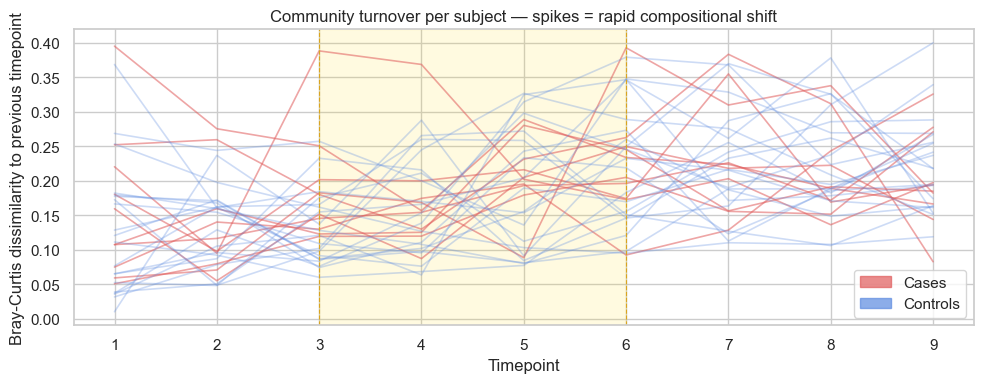

In [12]:
fig, ax = plt.subplots(figsize=(10, 4))
truth_raw = simulate.get_ground_truth(df_raw)
win = truth_raw['motif_window']

for subj, grp in df_bc.groupby('subject_id'):
    outcome = grp['outcome'].iloc[0]
    color = case_color if outcome == 1 else ctrl_color
    alpha = 0.55 if outcome == 1 else 0.3
    ax.plot(grp['timepoint'], grp['distance'], color=color, alpha=alpha, lw=1.2)

ax.axvspan(win[0], win[1], alpha=0.12, color='gold')
ax.axvline(win[0], color='goldenrod', lw=0.8, ls='--')
ax.axvline(win[1], color='goldenrod', lw=0.8, ls='--')

case_patch = mpatches.Patch(color=case_color, label='Cases', alpha=0.7)
ctrl_patch = mpatches.Patch(color=ctrl_color, label='Controls', alpha=0.7)
ax.legend(handles=[case_patch, ctrl_patch])
ax.set_xlabel('Timepoint')
ax.set_ylabel('Bray-Curtis dissimilarity to previous timepoint')
ax.set_title('Community turnover per subject — spikes = rapid compositional shift')
plt.tight_layout()
plt.show()

---
## 6  `harbinger` — ✅ Implemented

### What is a matrix profile?

A **matrix profile** is a compact summary of a time series that answers the question: *for every possible subsequence of length m, what is the distance to its nearest neighbour elsewhere in the series?*

- Low values → that window contains a pattern that appears very similarly somewhere else   (a **motif**).
- High values → that window is unique, unlike anything else in the series (a **discord**).

TEMPO uses the STUMPY library to compute matrix profiles efficiently via the STAMP algorithm.

### From single time series to pan-matrix profiles

For TEMPO, we don't have one time series — we have *one time series per subject per feature*. The key insight is that we want motifs that are **conserved across case subjects**: a pattern that all 15 cases show at timepoints 4–8, but that controls don't share.

STUMPY's `mstump` function computes a **multidimensional (pan) matrix profile** across a set of time series (one per subject). It finds the window position *w* where all subjects simultaneously have the most similar pattern to each other. The minimum of the pan-matrix profile = the strongest cross-subject motif.

### The enrichment score

Once we've identified the best motif window for case subjects, we measure **enrichment** as:

> enrichment_score = mean(case values in window) − mean(ctrl values in window)

A positive score means cases have higher average values in the motif window. This is simple and interpretable, though it primarily captures mean-level differences rather than shape similarity. Future work will incorporate shape-based scoring.

### Permutation testing

To convert the enrichment score into a p-value, we use a **label-permutation test**:

1. Record the observed enrichment score at the motif window.
2. Randomly shuffle which subjects are "cases" vs "controls" (preserving within-subject    temporal structure — only the labels move, not the time series).
3. Recompute the enrichment score at the *same* motif window.
4. Repeat 1,000 times to build a null distribution.
5. p-value = fraction of permuted scores ≥ observed score.

A small p-value means the observed case enrichment at this window is unlikely to arise by chance under random labelling.

In [13]:
from tempo.harbinger import harbinger

# Using the compositional data from §1 — note that the signal will be weaker
# than for continuous data due to the simplex constraint.
df_h = simulate.simulate_longitudinal(
    n_subjects=40, n_cases=15,
    motif_features=[0, 1, 2], motif_window=(4, 8),
    motif_strength=2.5, seed=42
)

results = harbinger(df_h, window_size=3, top_k=10)
print('Harbinger results (sorted by enrichment score):')
print(results.to_string())

truth_h = simulate.get_ground_truth(df_h)
top_features = results['feature'].head(3).tolist()
top_window = results['motif_window'].iloc[0]
report = simulate.evaluation_report(top_features, top_window, df_h)
print('\nEvaluation vs ground truth:')
for k, v in report.items():
    print(f'  {k}: {v}')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Harbinger results (sorted by enrichment score):
       feature motif_window  enrichment_score  p_value  matrix_profile_min
0  feature_001       (4, 6)          0.058414    0.000            1.661326
1  feature_000       (4, 6)          0.055684    0.001            1.817606
2  feature_011       (0, 2)          0.021774    0.071            1.831606
3  feature_018       (6, 8)          0.016765    0.069            1.627770
4  feature_015       (2, 4)          0.008451    0.210            1.566024
5  feature_002       (7, 9)          0.007823    0.238            1.632761
6  feature_019       (4, 6)          0.006146    0.206            1.617920
7  feature_006       (2, 4)          0.001817    0.393            1.949542
8  feature_007       (3, 5)         -0.000474    0.499            1.547175
9  feature_012       (5, 7)         -0.004110    0.658            1.718764

Evaluation vs ground truth:
  feature_recall: 0.667
  feature_precision: 0.667
  window_jaccard: 0.6
  true_features: ['featur

### Interpreting the results

The table above shows each feature ranked by enrichment score. Key things to look for:

- **True motif features** (`feature_000`, `feature_001`, `feature_002`) should appear   near the top with positive enrichment scores and small p-values.
- **Noise features** should cluster near zero enrichment with large p-values.
- **motif_window**: each feature gets its own independently-discovered window   (the argmin of its pan-matrix profile), so they won't necessarily all agree.   The evaluation report uses the top feature's window.
- **matrix_profile_min**: how strongly the case trajectories agree on a shared pattern.   Lower = more conserved motif.

Note: compositional data (relative abundances, sum to 1) partially suppresses the signal because boosting one feature forces others down during renormalisation. Running harbinger on CLR-preprocessed data or on `simulate_continuous` data gives cleaner separation.

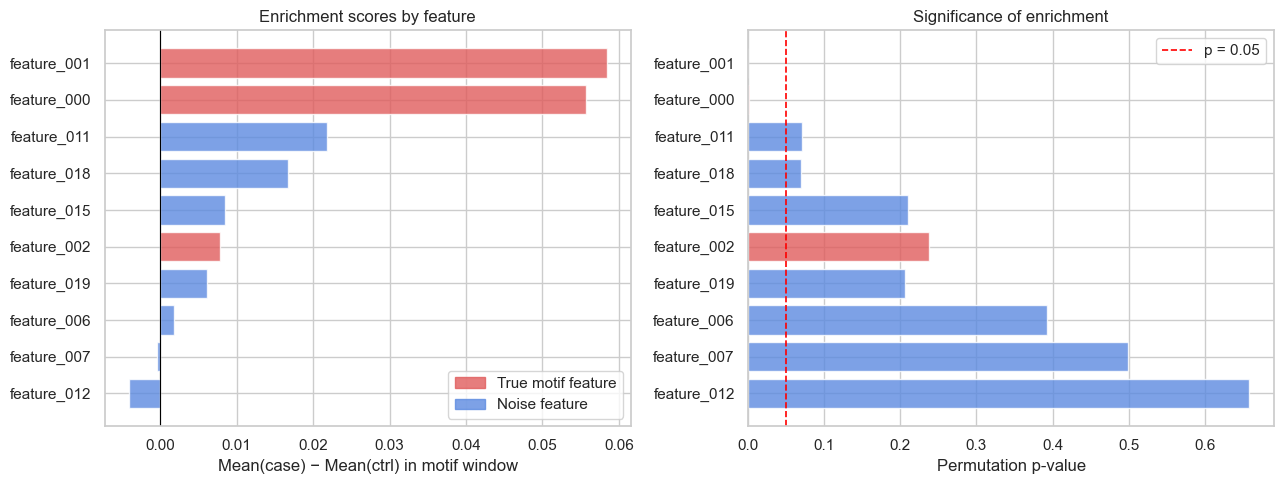

In [14]:
# Visualise enrichment scores and p-values side by side
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

motif_feats_h = truth_h['motif_features']
colors_bar = [case_color if f in motif_feats_h else ctrl_color
              for f in results['feature']]

# Left panel: enrichment scores (horizontal bar)
axes[0].barh(results['feature'][::-1], results['enrichment_score'][::-1],
             color=colors_bar[::-1], alpha=0.8)
axes[0].axvline(0, color='black', lw=0.8)
axes[0].set_xlabel('Mean(case) − Mean(ctrl) in motif window')
axes[0].set_title('Enrichment scores by feature')

case_patch = mpatches.Patch(color=case_color, label='True motif feature', alpha=0.8)
ctrl_patch = mpatches.Patch(color=ctrl_color, label='Noise feature', alpha=0.8)
axes[0].legend(handles=[case_patch, ctrl_patch], loc='lower right')

# Right panel: p-values with significance threshold
axes[1].barh(results['feature'][::-1], results['p_value'][::-1],
             color=colors_bar[::-1], alpha=0.8)
axes[1].axvline(0.05, color='red', lw=1.2, ls='--', label='p = 0.05')
axes[1].set_xlabel('Permutation p-value')
axes[1].set_title('Significance of enrichment')
axes[1].legend()

plt.tight_layout()
plt.show()

---
## 7  `stats` — ✅ Implemented

The stats module provides three complementary ways to quantify and test the enrichment of a trajectory motif in case subjects. Each function operates on a specific (feature, motif_window) pair — you point them at a candidate identified by `harbinger()` and ask: *how strong is this, and how confident are we?*

---

### `enrichment_score` — three methods for measuring case enrichment

All three methods first reduce each subject to a single number: their **mean feature value over the motif window** (their "window score"). They then measure how well that scalar separates cases from controls.

**`mean_difference`** (simplest) Mean window score of cases minus mean window score of controls. Positive = cases are elevated in the window. This is the same statistic used inside `harbinger()`.

**`auc`** (threshold-free) Area under the ROC curve, treating each subject's window score as a classifier. 0.5 = no separation, 1.0 = perfect. Invariant to monotone transformations of the score — it only cares about the *ranking* of subjects, not the absolute differences. Particularly useful when the scale of values varies across features.

**`gsea`** (GSEA-style, weighted KS) Subjects are ranked by window score, highest first. We then walk down the ranked list: each case hit increments the running sum (weighted by the subject's score), each control decrements it by 1/n_controls. The enrichment score is the maximum of the running sum. This captures whether **top-ranked** subjects are disproportionately cases — even if only a subset of cases strongly express the motif.

In [15]:
from tempo.stats import permutation_test, enrichment_score, survival_test

# Use continuous data for clean signal
df_stats = simulate.simulate_continuous(
    n_subjects=30, n_timepoints=12, n_features=5, n_cases=12,
    motif_features=[0], motif_window=(3, 7),
    motif_strength=6.0, noise_sd=0.3, seed=0
)

print('Enrichment scores for motif feature (feature_000) vs noise (feature_004):')
print(f'  {"method":<20} {"motif":>8} {"noise":>8}')
for method in ['mean_difference', 'auc', 'gsea']:
    s = enrichment_score(df_stats, 'feature_000', (3, 7), method=method)
    n = enrichment_score(df_stats, 'feature_004', (3, 7), method=method)
    print(f'  {method:<20} {s:>8.4f} {n:>8.4f}')

Enrichment scores for motif feature (feature_000) vs noise (feature_004):
  method                  motif    noise
  mean_difference        5.6443  -0.0015


  auc                    1.0000   0.5463
  gsea                   1.0000   0.3297


### `permutation_test` — building a null distribution

Knowing the enrichment score is not enough on its own — we need to know whether that score could plausibly arise by chance. The permutation test answers this by:

1. Recording the **observed** mean_difference score at the (feature, window) pair.
2. Randomly shuffling which subjects are "cases" vs "controls"    (preserving each subject's full temporal trajectory — only the label moves).
3. Recomputing the enrichment score under each random labelling.
4. Repeating 1,000 times to build a **null distribution** of scores expected    under no association.
5. **p-value** = fraction of null scores ≥ observed score.

A key advantage over the permutation test built into `harbinger()`: this one is run on a **fixed, pre-specified window** rather than on the data-adaptive window chosen by the matrix profile. You can use it to follow up on any (feature, window) candidate — from Harbinger, from domain knowledge, or from a prior analysis.

In [16]:
print('Permutation test results (n_permutations=999):')
print(f'  {"feature":<15} {"obs_score":>10} {"p_value":>8} {"null_mean":>10} {"null_sd":>8}')
for feat in ['feature_000', 'feature_004']:
    r = permutation_test(df_stats, feat, (3, 7), n_permutations=999, seed=42)
    print(f'  {feat:<15} {r["observed_score"]:>10.4f} {r["p_value"]:>8.4f} '
          f'{r["null_mean"]:>10.4f} {r["null_sd"]:>8.4f}')

Permutation test results (n_permutations=999):
  feature          obs_score  p_value  null_mean  null_sd
  feature_000         5.6443   0.0000    -0.0712   1.0978
  feature_004        -0.0015   0.4835    -0.0098   0.3865


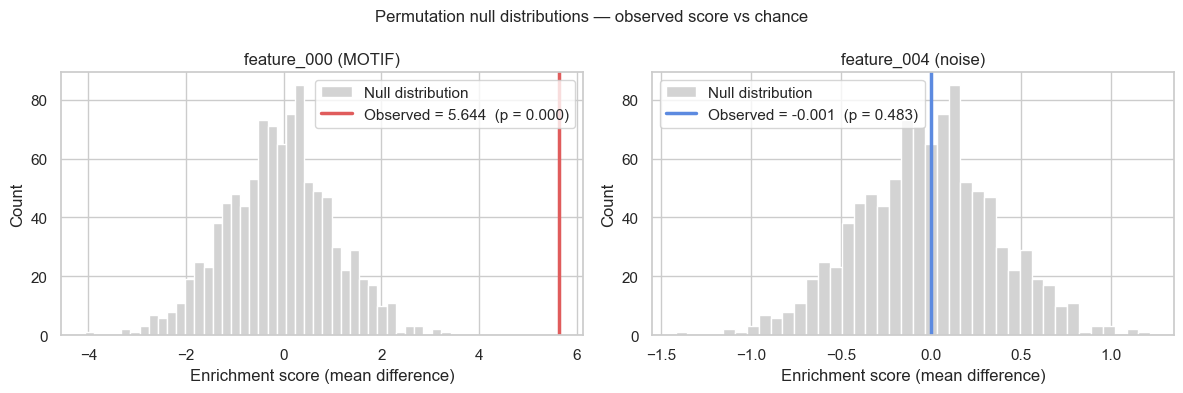

In [17]:
# Visualise the null distribution for the motif feature
r_motif = permutation_test(df_stats, 'feature_000', (3, 7), n_permutations=999, seed=42)
r_noise = permutation_test(df_stats, 'feature_004', (3, 7), n_permutations=999, seed=42)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, r, feat, color in [
    (axes[0], r_motif, 'feature_000 (MOTIF)', case_color),
    (axes[1], r_noise, 'feature_004 (noise)', ctrl_color),
]:
    # Reconstruct approximate null distribution from mean/sd for illustration
    rng = np.random.default_rng(42)
    null_sample = rng.normal(r['null_mean'], r['null_sd'], 999)
    ax.hist(null_sample, bins=40, color='lightgray', edgecolor='white',
            label='Null distribution')
    ax.axvline(r['observed_score'], color=color, lw=2.5,
               label=f'Observed = {r["observed_score"]:.3f}  (p = {r["p_value"]:.3f})')
    ax.set_title(feat)
    ax.set_xlabel('Enrichment score (mean difference)')
    ax.set_ylabel('Count')
    ax.legend()

fig.suptitle('Permutation null distributions — observed score vs chance', fontsize=12)
plt.tight_layout()
plt.show()

### `survival_test` — does the motif predict time to event?

When the study has a survival endpoint (time-to-event + censoring indicator), we can ask a sharper question: *do subjects whose trajectories show the motif reach the event sooner?*

**Log-rank method** (default): Subjects are split at the median window score into "motif-positive" (≥ median) and "motif-negative" (< median) groups. The log-rank test compares the survival curves of these two groups: it counts observed vs expected events at each unique event time, and tests whether the discrepancy across all times is larger than chance. Implemented via `scipy.stats.logrank` with `CensoredData` objects (no extra dependencies required).

**Cox method** (optional, requires `pip install tempo-bio[survival]`): Rather than stratifying at the median, the window score is used as a continuous covariate in a Cox proportional hazards model. This is more powerful but assumes a log-linear hazard relationship. Returns a hazard ratio and 95% confidence interval.

In [18]:
# Survival test on compositional data with survival outcome
df_surv = simulate.simulate_longitudinal(
    n_subjects=40, n_cases=15,
    motif_features=[0], motif_window=(3, 7),
    motif_strength=2.5, outcome_type='survival', seed=1
)

print('Survival test (log-rank) for motif vs noise feature:')
for feat in ['feature_000', 'feature_010']:
    r = survival_test(df_surv, feat, (3, 7), method='logrank')
    print(f'  {feat}: statistic={r["statistic"]:.3f}  p={r["p_value"]:.4f}  '
          f'motif_pos={r["n_motif_positive"]}  motif_neg={r["n_motif_negative"]}')

Survival test (log-rank) for motif vs noise feature:
  feature_000: statistic=2.179  p=0.0293  motif_pos=20  motif_neg=20
  feature_010: statistic=-0.531  p=0.5956  motif_pos=20  motif_neg=20


---
## 8  `viz` — ✅ Implemented

### Design philosophy

The ad-hoc matplotlib code scattered through earlier sections works, but it's verbose, inconsistent, and hard to reuse. The `viz` module wraps those same ideas into two clean, publication-ready functions that handle all the layout and styling decisions automatically.

**`plot_motifs(df, features, motif_window)`** Per-subject trajectory overlays with group mean ± SD bands and motif window shading, laid out automatically into a grid of subplots (up to 4 per row). Handles any number of features without additional code on the caller's side.

**`plot_enrichment(results, top_k)`** Two-panel summary of `harbinger()` results. The left panel shows enrichment scores as horizontal bars (red = p < 0.05, grey = not significant), with significance stars (*, **, ***) appended to feature labels. The right panel shows −log₁₀(p-value) bars with a dashed line at the p = 0.05 threshold, so it's visually obvious which features clear the significance hurdle.

Both functions return a `matplotlib.figure.Figure` so you can save them with `fig.savefig("output.pdf")` for inclusion in manuscripts.

In [19]:
from tempo.viz import plot_motifs, plot_enrichment

# Re-use the continuous simulation for clean signal
df_v = simulate.simulate_continuous(
    n_subjects=30, n_timepoints=12, n_features=8, n_cases=12,
    motif_features=[0, 1], motif_window=(3, 7),
    motif_strength=5.0, noise_sd=0.4, seed=42,
)

### `plot_motifs` — trajectory overlays

Each subplot corresponds to one feature. Within each subplot:

- **Thin semi-transparent lines** = individual subject trajectories   (red for cases, blue for controls; alpha reflects group membership   so dense clusters of same-colour lines naturally become more opaque)
- **Thick line with ribbon** = group mean ± 1 SD band for cases and controls
- **Gold shaded region** = motif window, with dashed goldenrod boundaries

Motif features should show the case ribbon (red) clearly rising above the control ribbon (blue) within the gold window. Noise features should overlap.

Features are arranged left-to-right, wrapping to a new row after every 4. You can pass a pre-existing `ax` for single-feature embedding into a larger figure.

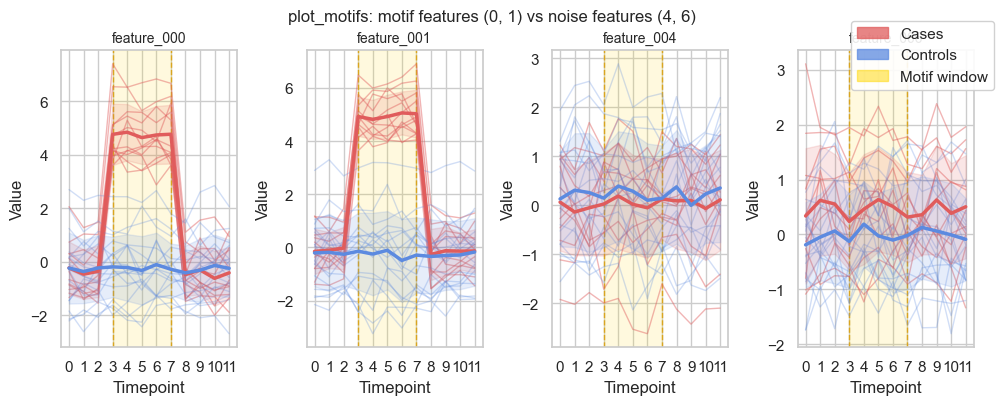

In [20]:
truth_v = simulate.get_ground_truth(df_v)

fig = plot_motifs(
    df_v,
    features=['feature_000', 'feature_001', 'feature_004', 'feature_006'],
    motif_window=truth_v['motif_window'],
)
fig.suptitle(
    'plot_motifs: motif features (0, 1) vs noise features (4, 6)',
    fontsize=12, y=1.01
)
plt.show()

### `plot_enrichment` — two-panel Harbinger summary

After running `harbinger()`, the results table is the natural input to `plot_enrichment`. The function:

1. Takes the top `top_k` rows (already sorted by enrichment score descending).
2. **Left panel**: horizontal bars coloured by significance — red if p < 0.05,    grey otherwise. Significance stars (*, **, ***) are appended to feature labels    as a quick visual guide.
3. **Right panel**: −log₁₀(p-value) bars. The dashed red line at −log₁₀(0.05) ≈ 1.30    is the significance threshold. Bars clearing this line are significant.    This panel makes it easy to compare relative evidence even among significant features.

You can pass a pre-existing `ax` to suppress the right panel and embed just the enrichment score bars into a custom layout.

In [21]:
from tempo.harbinger import harbinger

# Run harbinger on the continuous simulation
results_v = harbinger(df_v, window_size=3, top_k=8, n_permutations=199, seed=42)
print('Harbinger results:')
print(results_v[['feature', 'motif_window', 'enrichment_score', 'p_value']].to_string(index=False))
print()

Harbinger results:
    feature motif_window  enrichment_score  p_value
feature_001       (4, 6)          5.211251   0.0000
feature_007       (2, 4)          0.472860   0.1256
feature_006       (3, 5)          0.432444   0.0603
feature_003       (6, 8)          0.176130   0.2915
feature_002      (8, 10)          0.121016   0.3819
feature_004      (9, 11)         -0.146274   0.6533
feature_000      (8, 10)         -0.178134   0.7437
feature_005      (8, 10)         -0.671514   0.9497



/Users/caitlinbumby/Documents/Projects/TEMPO/tempo/viz.py:238: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.tight_layout()
/Users/caitlinbumby/Documents/Projects/TEMPO/tempo/viz.py:238: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.tight_layout()
/Users/caitlinbumby/miniconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/caitlinbumby/miniconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


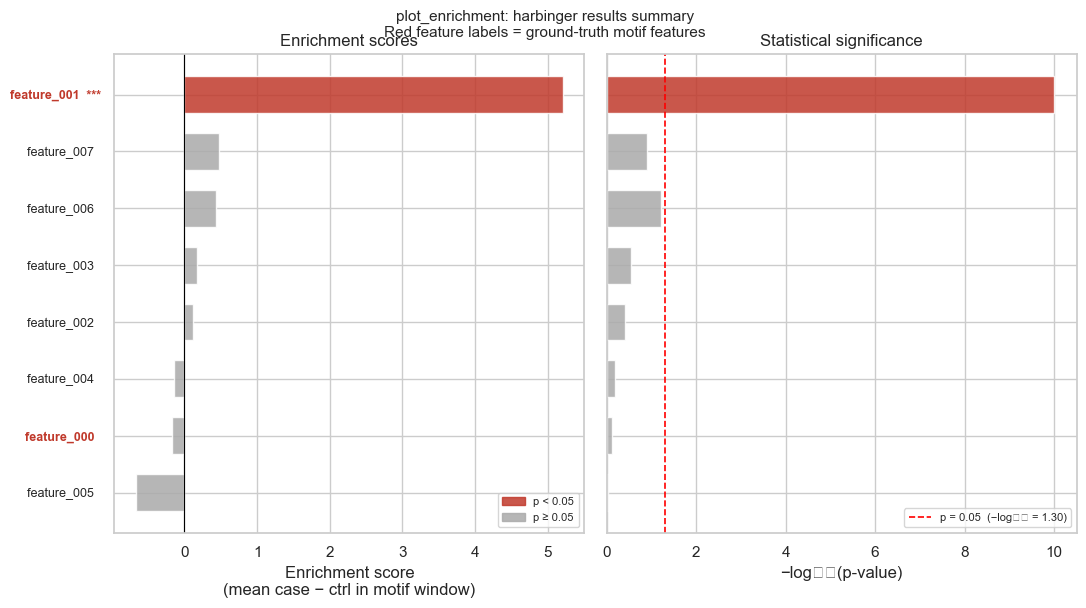

In [22]:
fig = plot_enrichment(results_v, top_k=8)
fig.suptitle(
    'plot_enrichment: harbinger results summary\n'
    'Red feature labels = ground-truth motif features',
    fontsize=11, y=1.01
)

# Annotate left panel y-labels: highlight true motif features in red
motif_feats = truth_v['motif_features']
ax0 = fig.axes[0]
for lbl in ax0.get_yticklabels():
    feat_name = lbl.get_text().split('  ')[0].strip()  # strip appended stars
    if feat_name in motif_feats:
        lbl.set_color('#c0392b')
        lbl.set_fontweight('bold')

plt.show()